## Short Introduction

Customer segmentation is a process used by businesses to divide their customer base into distinct groups, or segments, based on common characteristics, behaviors, or demographics. These segments allow businesses to better understand their customers and tailor their strategies accordingly.

The goal of this notebook is to perform customer segmentation using unsupervised learning techniques. By clustering customers into meaningful groups, I aim to provide actionable insights for the marketing team to:

- Narrow their marketing campaigns
- Design targeted promotions for specific customer groups
- Improve customer engagement and satisfaction


## Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector 
from sklearn.impute import SimpleImputer  
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, AffinityPropagation
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
import itertools
import warnings
from matplotlib.colors import LinearSegmentedColormap

In [2]:
df = pd.read_csv("/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## Exploratory Data Analysis

In [3]:
customers = df.copy()

In [4]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


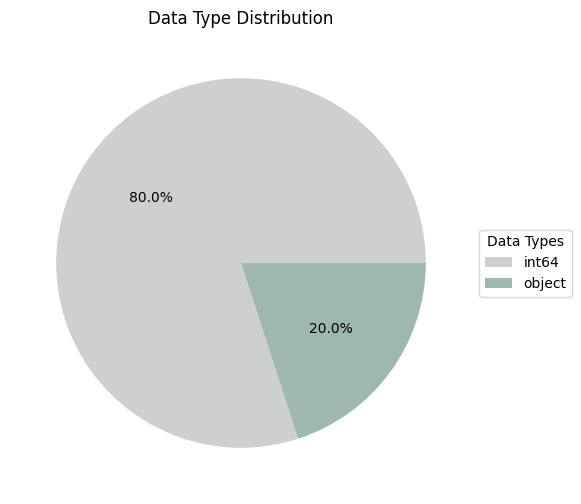

In [5]:
def plot_dtype_distribution(df):

    dtype_counts = df.dtypes.value_counts()

    total_columns = len(df.columns)
    dtype_percentages = (dtype_counts / total_columns) * 100

    colors = ["#CED0CE", "#9FB8AD", "#6B815F"]
    
    plt.figure(figsize=(8,6))
    wedges, texts, autotexts = plt.pie(dtype_percentages, colors = colors, autopct="%.1f%%", startangle=0)
    plt.legend(wedges, dtype_counts.index, title="Data Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    plt.title("Data Type Distribution")
    plt.show()

plot_dtype_distribution(customers)

In [6]:
def plot_missing_values(df):

    missing_percentages = (df.isnull().sum() / len(df)) * 100
    missing_percentages = missing_percentages[missing_percentages > 0]

    if not missing_percentages.empty:
        plt.figure(figsize=(10,6))
        missing_percentages.sort_values().plot(kind = "bar", color = "#9FB8AD")
        plt.xlabel("Columns")
        plt.ylabel("% of missing values")
        plt.title("Percentage of Missing Values in Each Column")
        plt.xticks(rotation=45, ha = "right")
        plt.tight_layout()
        plt.show()

    else:
        print("No columns with missing values!")

plot_missing_values(customers)

No columns with missing values!


In [7]:
def show_column_info(df):

    column_info = {
        "Column": [],
        "Data Type": [],
        "Unique Values": []
    }

    for column in df.columns:
        column_info["Column"].append(column)
        column_info["Data Type"].append(df[column].dtype)
        column_info["Unique Values"].append(df[column].nunique())

    column_info_df = pd.DataFrame(column_info)
    return print(column_info_df)

show_column_info(customers)

                   Column Data Type  Unique Values
0              CustomerID     int64            200
1                  Gender    object              2
2                     Age     int64             51
3      Annual Income (k$)     int64             64
4  Spending Score (1-100)     int64             84


In [8]:
def show_frequent_values(df, threshold):
    for column in df.columns:
        value_counts = df[column].value_counts(normalize=True) * 100
        frequent_values = value_counts[value_counts >= threshold]

        if not frequent_values.empty:
            print(frequent_values)
            print()

show_frequent_values(customers, 30)

Gender
Female    56.0
Male      44.0
Name: proportion, dtype: float64



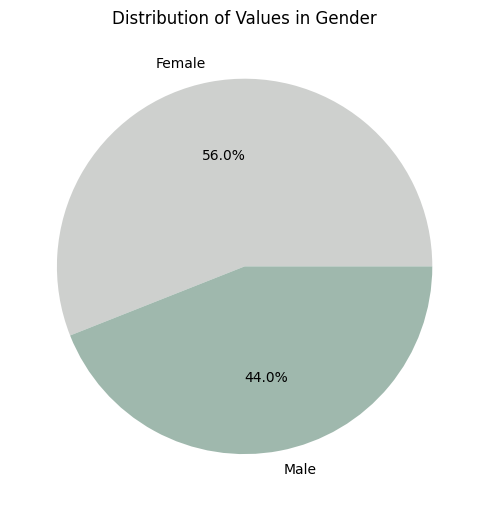

In [9]:
def pie_chart_of_columns(df, max_unique_values):
    
    columns_to_plot = [column for column in df.columns if df[column].nunique() < max_unique_values]

    num_plots = len(columns_to_plot)

    num_rows = (num_plots // 3) + (1 if num_plots % 3 != 0 else 0)

    plt.figure(figsize=(15, num_rows * 5))
    
    for idx, column in enumerate(columns_to_plot, 1):
        value_counts = df[column].value_counts(normalize=True) * 100

        plt.subplot(num_rows, 3, idx)
        plt.pie(value_counts, labels=value_counts.index, autopct="%.1f%%", startangle=0, 
                colors=["#CED0CE", "#9FB8AD", "#6B815F", "#364958", "#93748A"])
        plt.title(f"Distribution of Values in {column}")

    plt.tight_layout()
    plt.show()

pie_chart_of_columns(customers, 5)

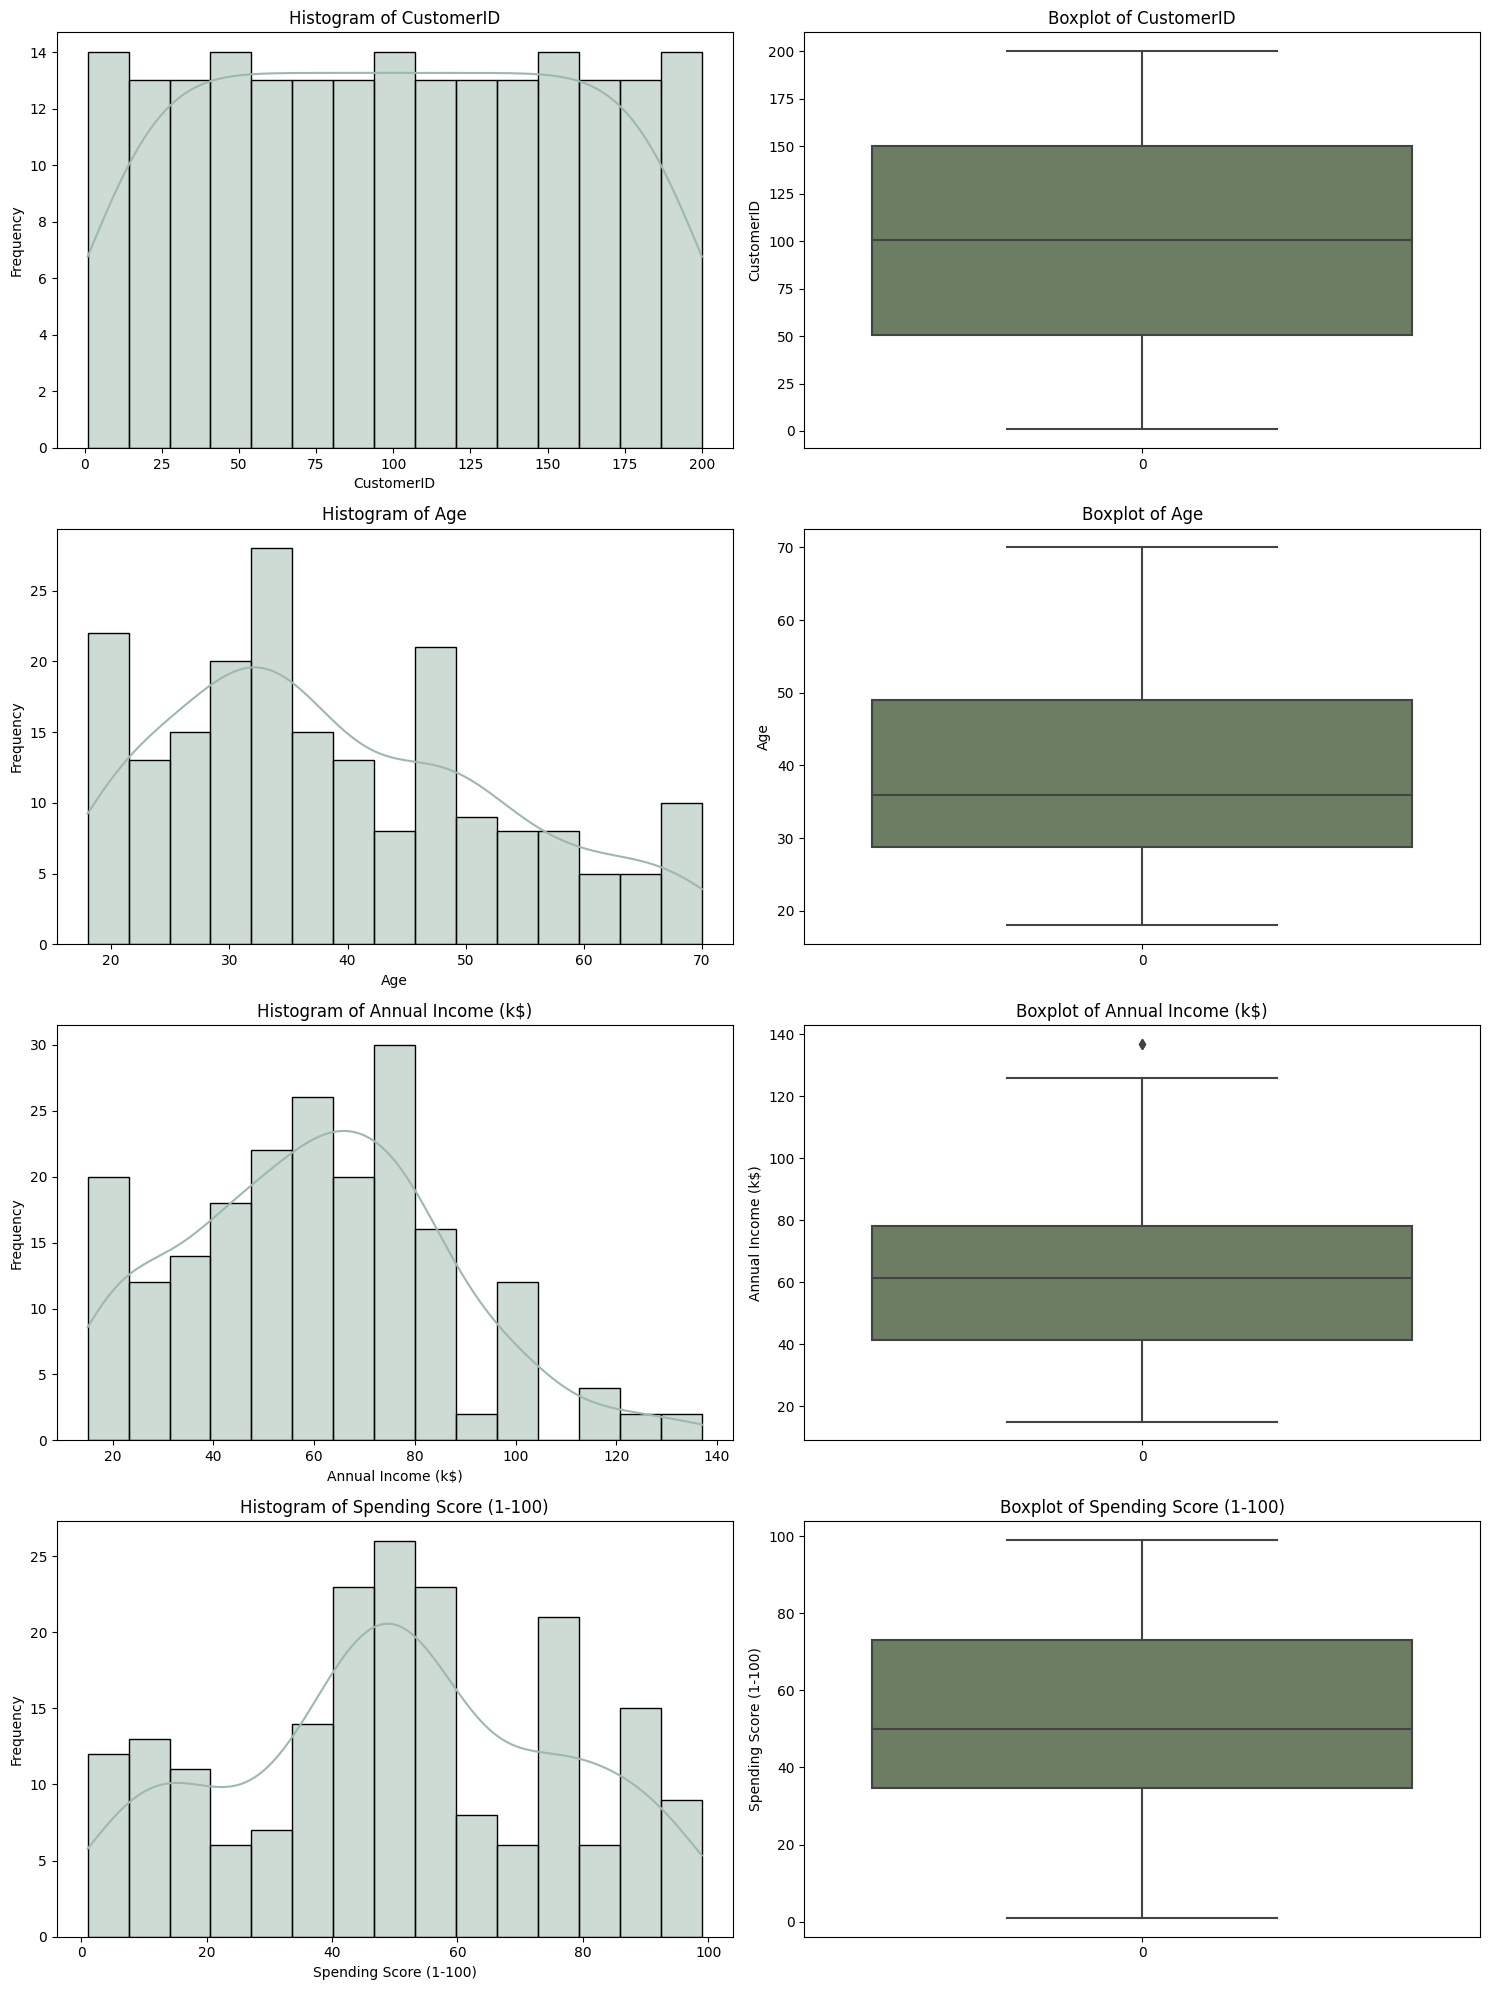

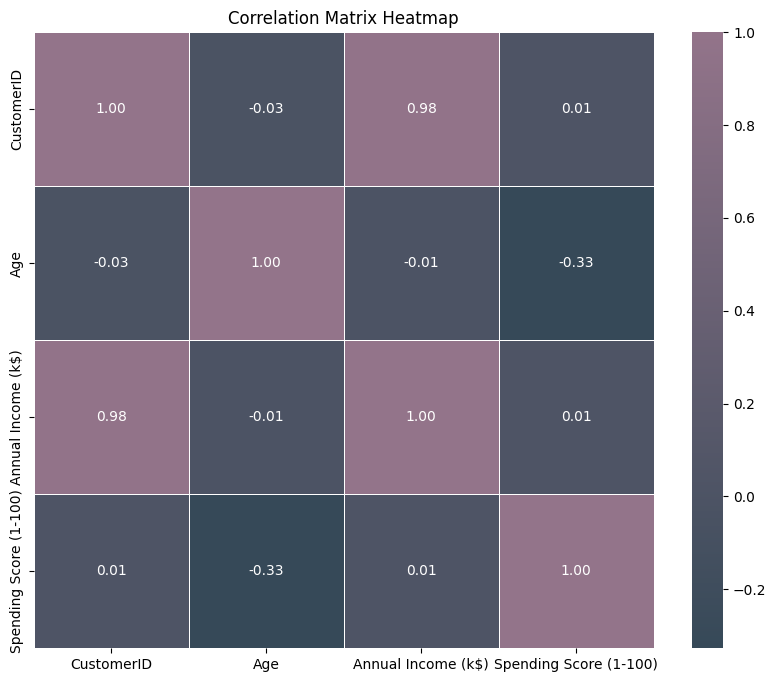

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


In [10]:
warnings.simplefilter(action='ignore', category=FutureWarning)

custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", ["#364958", "#93748A"])

def analyze_filtered_data(df, min_unique_values, bins):

        filtered_columns = [column for column in df.columns if df[column].nunique() > min_unique_values]
        filtered_data = df[filtered_columns]
    
        
        num_columns = len(filtered_columns)
        plots_per_row = 2  
    
        fig, axes = plt.subplots(num_columns, plots_per_row, figsize=(15, 5 * num_columns))
        axes = axes.flatten()
    
        for idx, column in enumerate(filtered_columns):
            
            sns.histplot(filtered_data[column], bins=bins, kde=True, ax=axes[2 * idx], color="#9FB8AD")
            axes[2 * idx].set_title(f"Histogram of {column}")
            axes[2 * idx].set_xlabel(column)
            axes[2 * idx].set_ylabel("Frequency")
    
           
            sns.boxplot(data=filtered_data[column], ax=axes[2 * idx + 1], color="#6B815F")
            axes[2 * idx + 1].set_title(f"Boxplot of {column}")
            axes[2 * idx + 1].set_ylabel(column)
    
      
        for idx in range(num_columns * 2, len(axes)):
            fig.delaxes(axes[idx])
    
        plt.tight_layout()
        plt.show()
    
        corr_matrix = filtered_data.corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap=custom_cmap, fmt=".2f", cbar=True, linewidths=0.5)
        plt.title("Correlation Matrix Heatmap")
        plt.show()
        return filtered_data.describe().transpose()


analyze_filtered_data(customers, 5, 15)

## Data Preprocessing

In [11]:
X_train = customers.copy()

In [12]:
def log_transform(X):
    return np.log(X + 1e-9)
    
cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), 
                             OneHotEncoder(drop="first", handle_unknown="ignore"))
log_pipeline = make_pipeline(SimpleImputer(strategy="median"), 
                             FunctionTransformer(log_transform, feature_names_out="one-to-one"),
                             StandardScaler())
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"), 
                                     StandardScaler())

preprocessing = ColumnTransformer([
    ("drop_columns", "drop", ["CustomerID"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include = object)),
    ("log", log_pipeline, ["Age", "Annual Income (k$)"]),
],
    remainder=default_num_pipeline)

X_prepared = preprocessing.fit_transform(X_train)
preprocessing.get_feature_names_out()

array(['cat__Gender_Male', 'log__Age', 'log__Annual Income (k$)',
       'remainder__Spending Score (1-100)'], dtype=object)

SimpleImputer was used to handle potential missing values in case the model is used in the future, even though the current dataset does not have any missing values.


## Feature Selection

The goal of this section was to identify the best set of variables, i.e., the set with the highest silhouette score. I assumed that the variable *'Spending Score (1-100)'* is crucial for the marketing team to develop targeted strategies. Therefore, I tested different combinations of variables, ensuring that each combination included *'Spending Score (1-100)'*, to determine the optimal set.

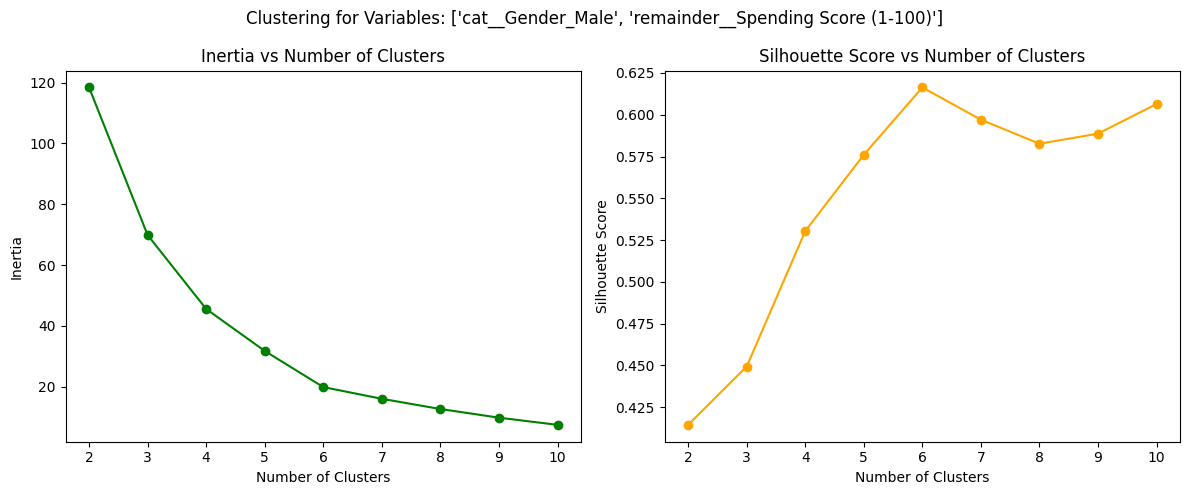

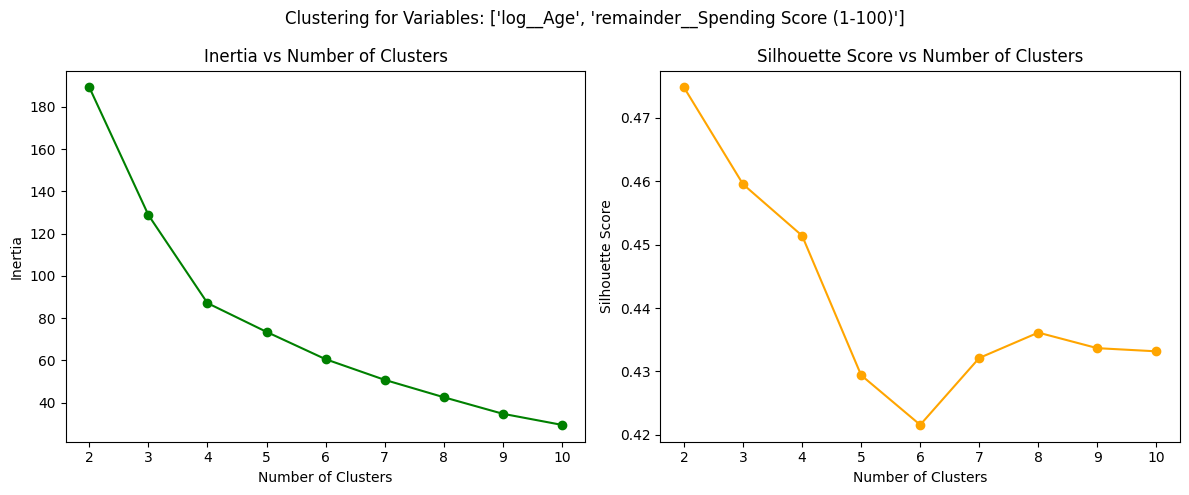

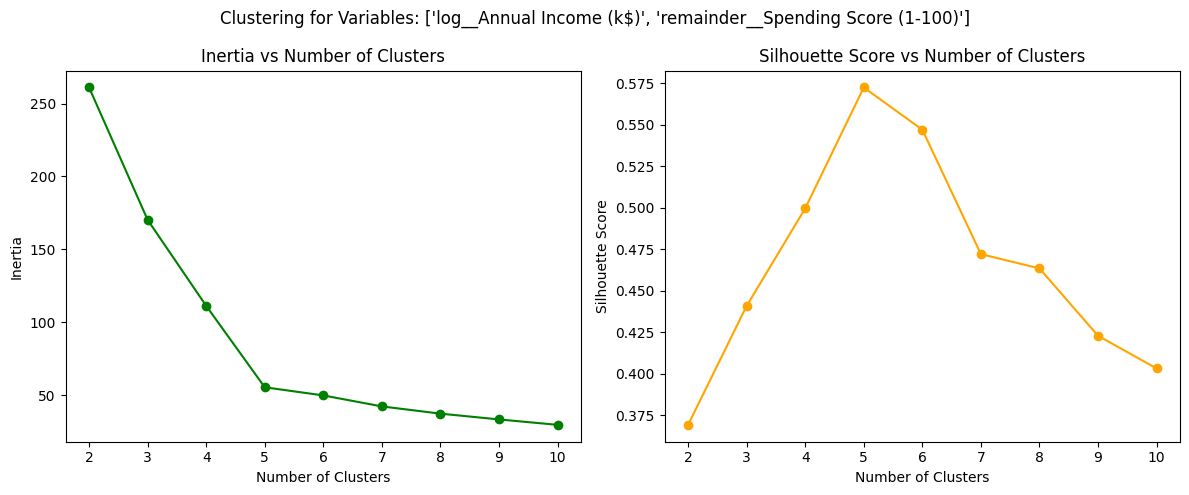

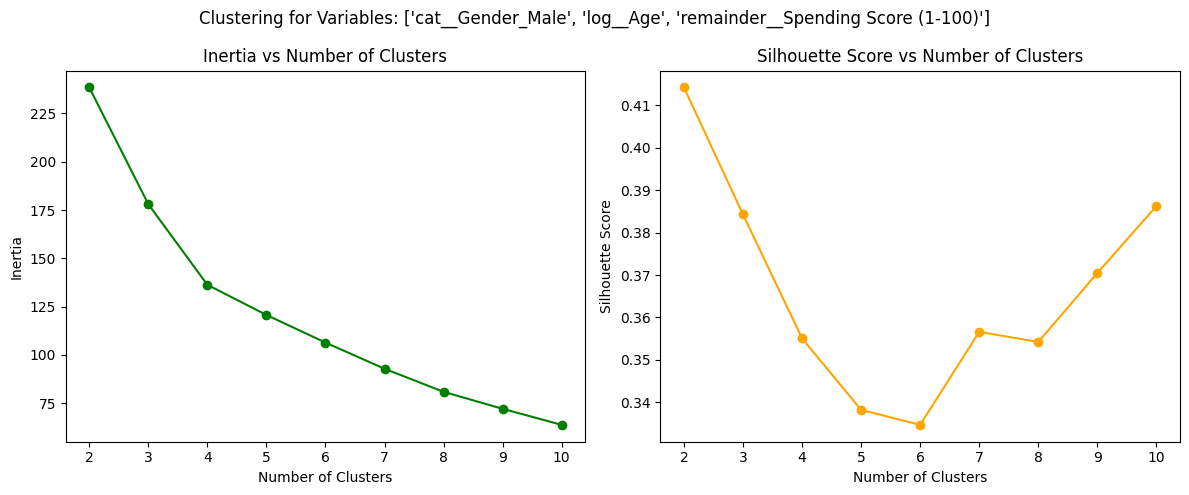

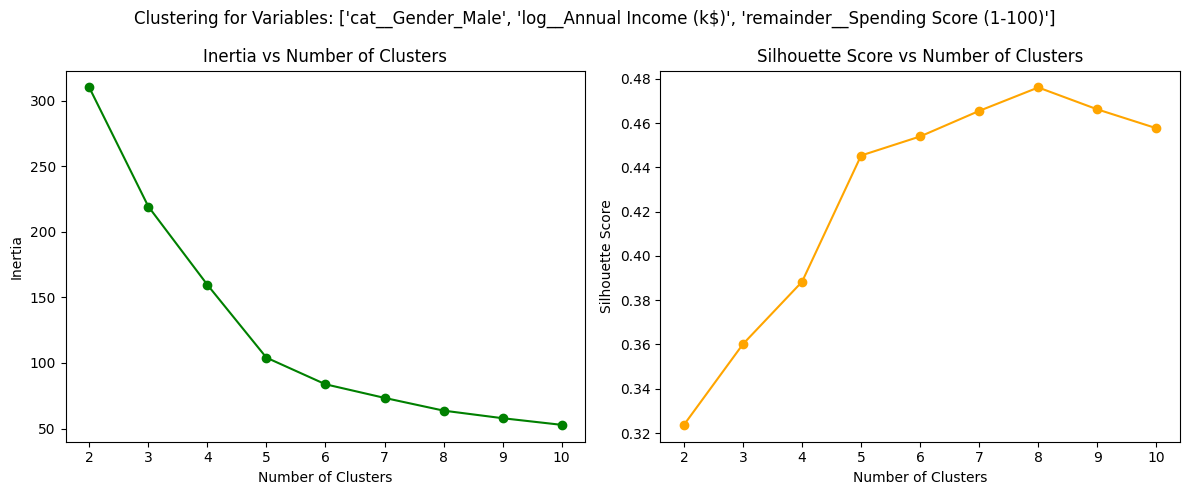

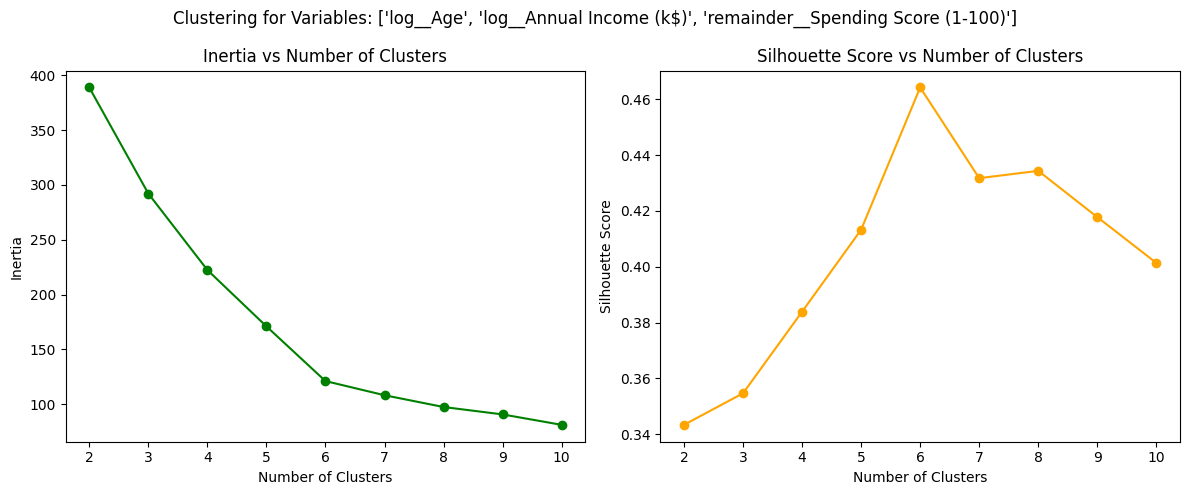

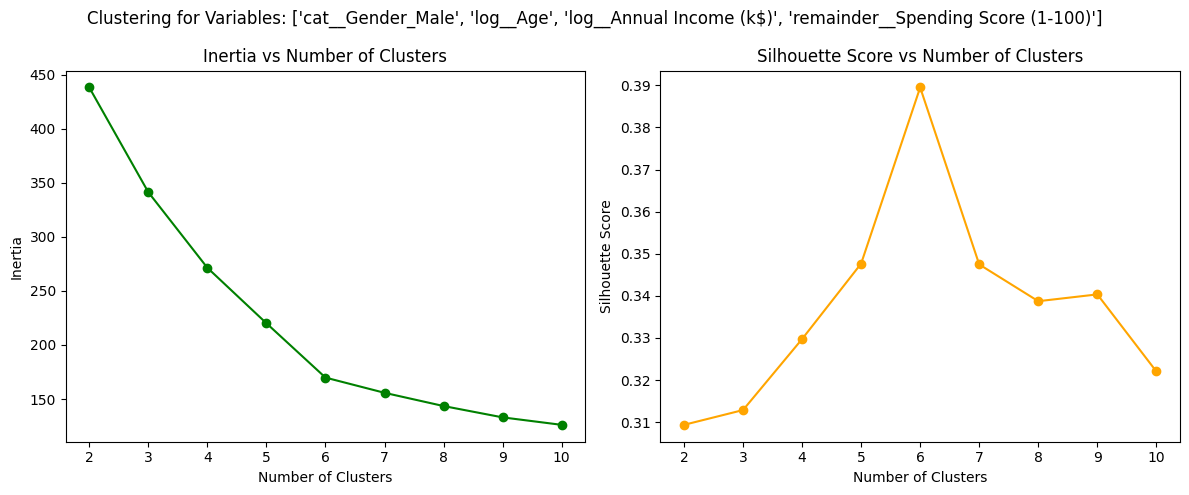

In [13]:
X_prepared_df = pd.DataFrame(X_prepared, columns = ['cat__Gender_Male', 'log__Age', 
                                                    'log__Annual Income (k$)','remainder__Spending Score (1-100)'] )

unfixed_variables = ["cat__Gender_Male", "log__Age", "log__Annual Income (k$)"]
fixed_variable = ["remainder__Spending Score (1-100)"]

cluster_range = range(2,11)

for r in range(1, len(unfixed_variables) + 1):
    subsets = itertools.combinations(unfixed_variables, r)

    for subset in subsets:
        included_variables = list(subset) + fixed_variable

        X = X_prepared_df[included_variables]

        inertia = []
        silhouette_scores = []

        for k in cluster_range:

            kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
            cluster_labels = kmeans.fit_predict(X)

            inertia.append(kmeans.inertia_)

            if len(np.unique(cluster_labels)) > 1:
                score = silhouette_score(X, cluster_labels)
                silhouette_scores.append(score)

            else: 
                silhouette_scores.append(np.nan)

        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(cluster_range, inertia, marker = "o", color = "green")
        plt.title("Inertia vs Number of Clusters")
        plt.xlabel("Number of Clusters")
        plt.ylabel("Inertia")

        plt.subplot(1,2,2)
        plt.plot(cluster_range, silhouette_scores, marker = "o", color = "orange")
        plt.title("Silhouette Score vs Number of Clusters")
        plt.xlabel("Number of Clusters")
        plt.ylabel("Silhouette Score")

        plt.suptitle(f"Clustering for Variables: {included_variables}")
        plt.tight_layout()
        plt.show()
        print("")
        print("")
        print("")

There were two candidate sets:

- Gender and Spending Score
- Income and Spending Score

After plotting both sets, I determined that *Income and Spending Score* was the best set of variables to select.

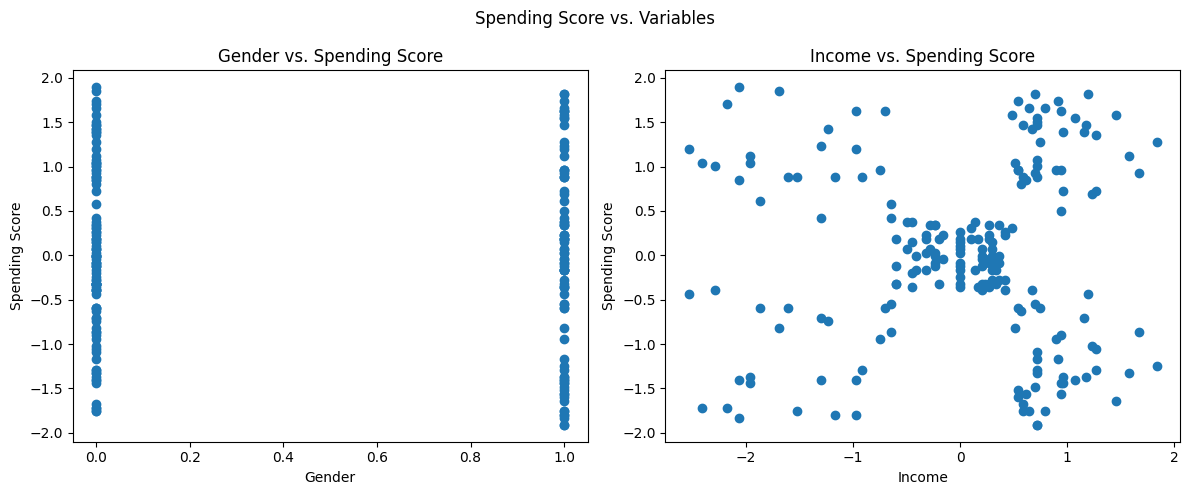

In [14]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(X_prepared_df["cat__Gender_Male"], X_prepared_df["remainder__Spending Score (1-100)"], marker = "o")
plt.title("Gender vs. Spending Score")
plt.xlabel("Gender")
plt.ylabel("Spending Score")

plt.subplot(1,2,2)
plt.scatter(X_prepared_df["log__Annual Income (k$)"], X_prepared_df["remainder__Spending Score (1-100)"], marker = "o")
plt.title("Income vs. Spending Score")
plt.xlabel("Income")
plt.ylabel("Spending Score")

plt.suptitle("Spending Score vs. Variables")
plt.tight_layout()
plt.show()

## Model Selection

In this section, I experimented with several clustering algorithms to identify the best model for customer segmentation. The following algorithms were tried:

- **KMeans**
- **Gaussian Mixture**
- **Affinity Propagation**
- **Mean Shift**

These algorithms were selected based on their ability to handle different types of clusters and their performance in identifying meaningful customer segments.


In [15]:
X_new = X_prepared_df[["log__Annual Income (k$)", "remainder__Spending Score (1-100)"]]

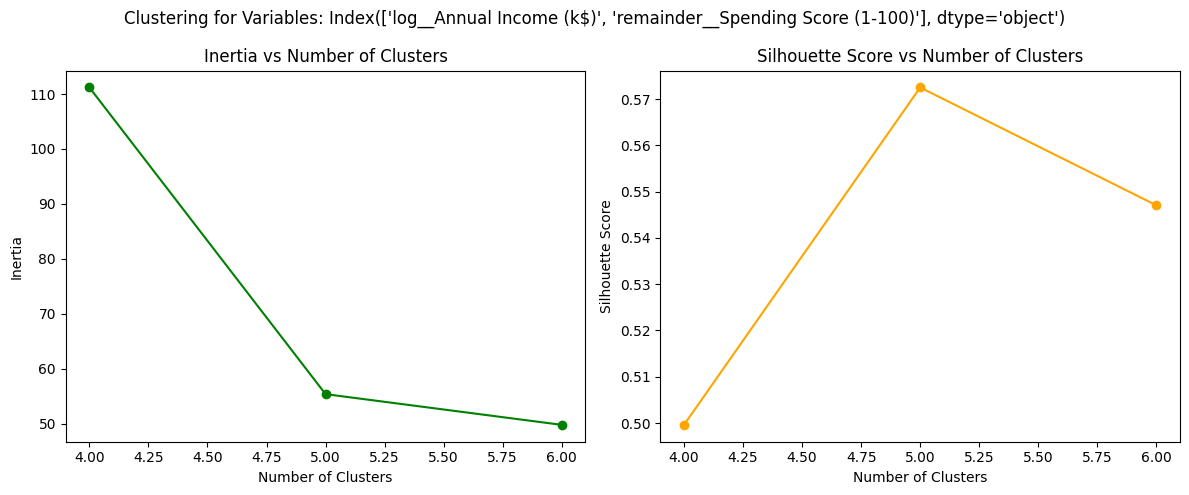

In [16]:
inertia = []
silhouette_scores = []

for k in [4, 5, 6]:

        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        cluster_labels = kmeans.fit_predict(X_new)

        inertia.append(kmeans.inertia_)

        if len(np.unique(cluster_labels)) > 1:
                score = silhouette_score(X_new, cluster_labels)
                silhouette_scores.append(score)

        else: 
            silhouette_scores.append(np.nan)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot([4, 5, 6], inertia, marker = "o", color = "green")
plt.title("Inertia vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot([4, 5, 6], silhouette_scores, marker = "o", color = "orange")
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")

plt.suptitle(f"Clustering for Variables: {X_new.columns}")
plt.tight_layout()
plt.show()

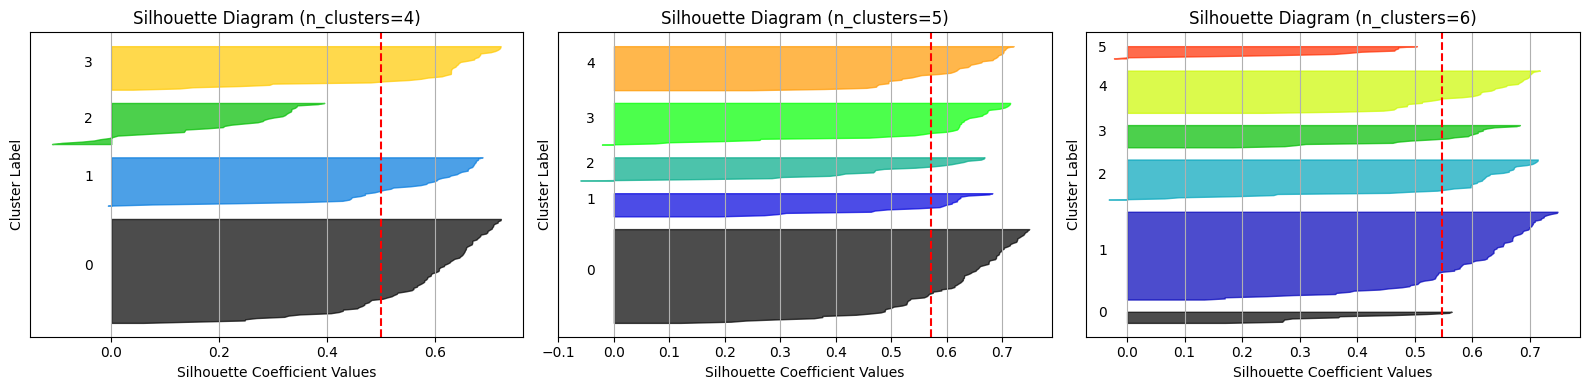

In [17]:
n_plots = len(range(4,7))
plt.figure(figsize=(16, 4))
for n_clusters in range(4,7):
    
    plt.subplot(1, n_plots, n_clusters%4 + 1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_new)
    silhouette_vals = silhouette_samples(X_new, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
        ith_cluster_silhouette_vals.sort()
        size_cluster_i = ith_cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_vals,
                          facecolor=color, edgecolor=color, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    plt.title(f"Silhouette Diagram (n_clusters={n_clusters})")
    plt.xlabel("Silhouette Coefficient Values")
    plt.ylabel("Cluster Label")
    plt.axvline(x=np.mean(silhouette_vals), color="red", linestyle="--")
    plt.yticks([])
    plt.grid()
    
    
plt.tight_layout()
plt.show()

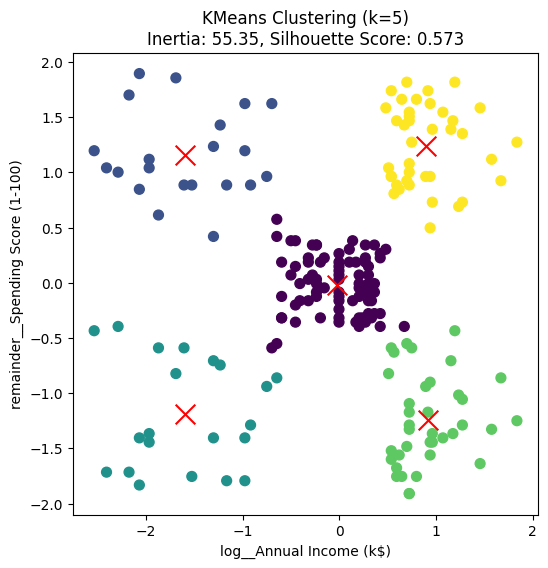

In [18]:
k_best = 5

kmeans = KMeans(n_clusters = k_best, n_init = 10, random_state = 42)
labels = kmeans.fit_predict(X_new)

inertia = kmeans.inertia_
silhouette_avg = silhouette_score(X_new, labels)

plt.figure(figsize=(6,6))
plt.scatter(X_new.iloc[:,0], X_new.iloc[:,1], c=labels, cmap="viridis", s=50)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], color="red", s=200, marker="x")
plt.title(f"KMeans Clustering (k={k_best})\nInertia: {inertia:.2f}, Silhouette Score: {silhouette_avg:.3f}")
plt.xlabel("log__Annual Income (k$)")
plt.ylabel("remainder__Spending Score (1-100)")
plt.show()

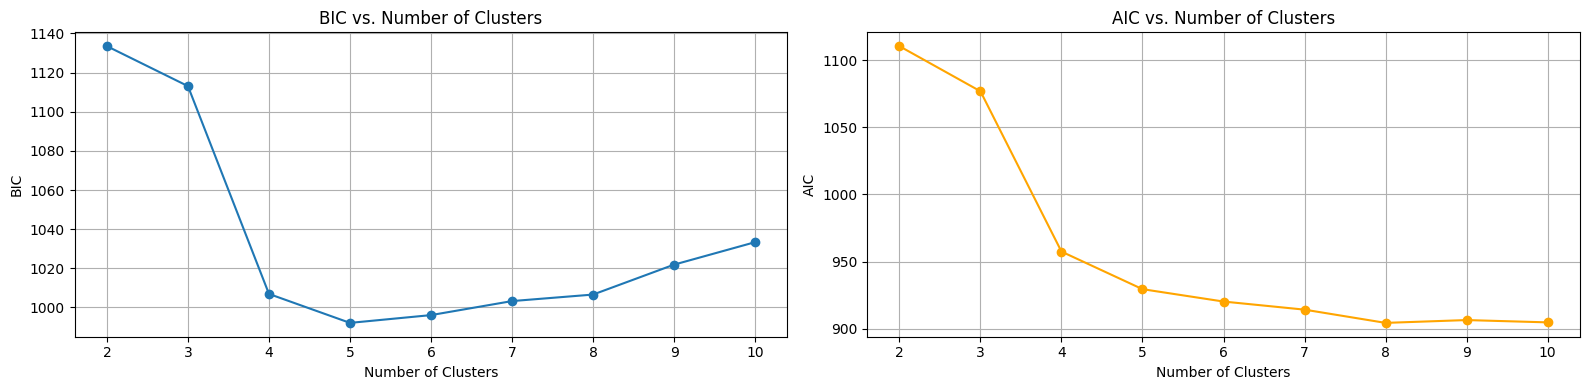

In [19]:
cluster_range = range(2, 11)

bic = []
aic = []

for n_clusters in cluster_range:
    gm = GaussianMixture(n_components=n_clusters, covariance_type="spherical", n_init=10)
    labels = gm.fit_predict(X_new)
    
    bic.append(gm.bic(X_new))
    
    aic.append(gm.aic(X_new))

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, bic, marker='o')
plt.title("BIC vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("BIC")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(cluster_range, aic, marker='o', color='orange')
plt.title("AIC vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("AIC")
plt.grid()

plt.tight_layout()
plt.show()

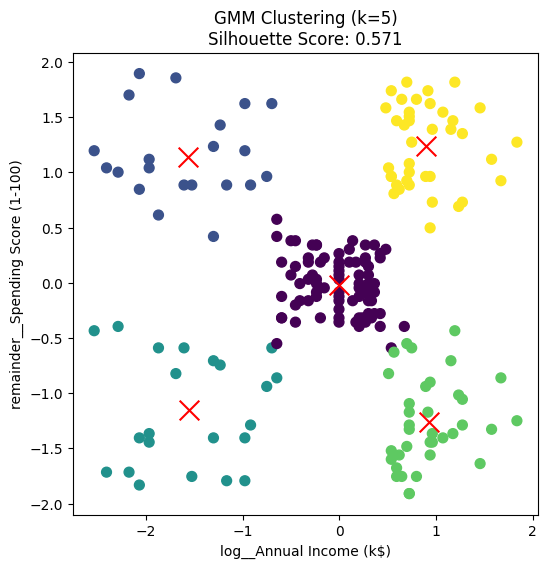

In [20]:
best_k_gmm = 5  

gmm = GaussianMixture(n_components=best_k_gmm, covariance_type="spherical", random_state=42)
labels_gmm = gmm.fit_predict(X_new)

silhouette_avg_gmm = silhouette_score(X_new, labels_gmm)

plt.figure(figsize=(6, 6))
plt.scatter(X_new.iloc[:, 0], X_new.iloc[:, 1], c=labels_gmm, cmap='viridis', s=50)
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], 
            c='red', s=200, marker='x', label='Cluster Centers')
plt.title(f"GMM Clustering (k={best_k_gmm})\nSilhouette Score: {silhouette_avg_gmm:.3f}")
plt.xlabel("log__Annual Income (k$)")
plt.ylabel("remainder__Spending Score (1-100)")
plt.show()

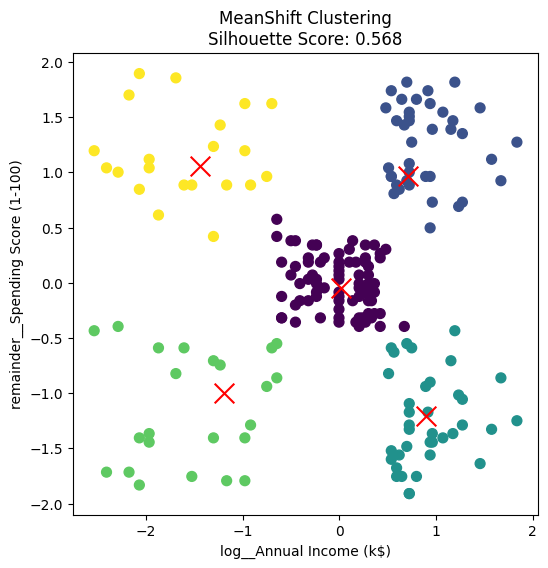

In [21]:
bandwidth = estimate_bandwidth(X_new, quantile=0.2)
meanshift = MeanShift(bandwidth=bandwidth)
labels_ms = meanshift.fit_predict(X_new)
cluster_centers = meanshift.cluster_centers_

silhouette_avg_ms = silhouette_score(X_new, labels_ms)

plt.figure(figsize=(6, 6))
plt.scatter(X_new.iloc[:, 0], X_new.iloc[:, 1], c=labels_ms, cmap='viridis', s=50)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=200)
plt.title(f"MeanShift Clustering\nSilhouette Score: {silhouette_avg_ms:.3f}")
plt.xlabel("log__Annual Income (k$)")
plt.ylabel("remainder__Spending Score (1-100)")
plt.show()

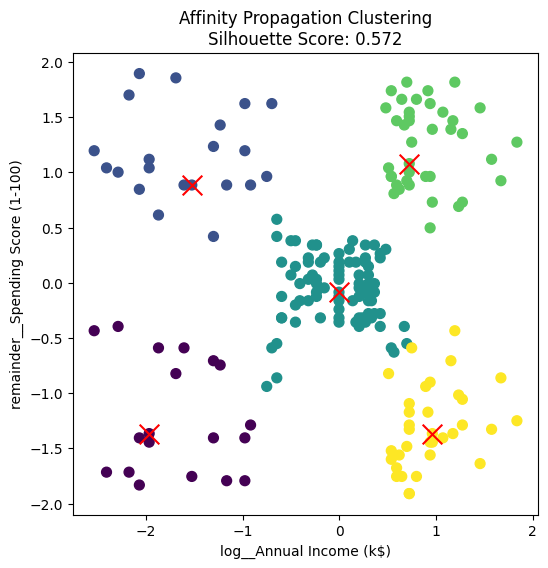

In [22]:
affinity_propagation = AffinityPropagation(preference=-50, random_state=42)
labels_ap = affinity_propagation.fit_predict(X_new)
cluster_centers_ap = affinity_propagation.cluster_centers_

silhouette_avg_ap = silhouette_score(X_new, labels_ap)

plt.figure(figsize=(6, 6))
plt.scatter(X_new.iloc[:, 0], X_new.iloc[:, 1], c=labels_ap, cmap='viridis', s=50)
plt.scatter(cluster_centers_ap[:, 0], cluster_centers_ap[:, 1], c='red', marker='x', s=200)
plt.title(f"Affinity Propagation Clustering\nSilhouette Score: {silhouette_avg_ap:.3f}")
plt.xlabel("log__Annual Income (k$)")
plt.ylabel("remainder__Spending Score (1-100)")
plt.show()

## Final Model

In [23]:
def log_transform(X):
    return np.log(X + 1e-9)
    
log_pipeline = make_pipeline(SimpleImputer(strategy="median"), 
                             FunctionTransformer(log_transform, feature_names_out="one-to-one"),
                             StandardScaler())
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"), 
                                     StandardScaler())

preprocessing_final = ColumnTransformer([
    ("drop_columns", "drop", ["CustomerID", "Gender", "Age"]),
    ("log", log_pipeline, ["Annual Income (k$)"]),
],
    remainder=default_num_pipeline)

X_prepared_final = preprocessing_final.fit_transform(X_train)
preprocessing_final.get_feature_names_out()

array(['log__Annual Income (k$)', 'remainder__Spending Score (1-100)'],
      dtype=object)

In [24]:
final_model = Pipeline([
    ("preprocessing", preprocessing_final),
    ("KMeans", KMeans(n_clusters = 5, n_init = 10, random_state = 42)),
])

In [25]:
final_labels = final_model.fit_predict(X_train)

In [26]:
X_final = X_train.copy()
X_final["Cluster"] = final_labels
X_final.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,Male,19,15,39,2
1,2,Male,21,15,81,1
2,3,Female,20,16,6,2
3,4,Female,23,16,77,1
4,5,Female,31,17,40,2


## Customer Segmentation: Final Clusters and Recommendations

For the final insights and recommendations, a graphical method was used to distinguish the clusters. Additionally, I defined the 10th to 90th percentiles to check if they align with the clusters. While this is unnecessary for 2D plots, it can be useful when working with more than three dimensions.


In [27]:
def percentile_bounds(data, lower_percentile, upper_percentile):
   
    lower = np.percentile(data, lower_percentile)
    upper = np.percentile(data, upper_percentile)
    mean = np.mean(data)
    return lower, mean, upper

numeric_cols = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]

ci_results = []

lower_percentile = 10
upper_percentile = 90

for cluster, group in X_final.groupby("Cluster"):
    cluster_result = {"Cluster": cluster}
    for col in numeric_cols:
        lower, mean, upper = percentile_bounds(group[col], lower_percentile, upper_percentile)
        cluster_result[f"{col} Percentile Bounds"] = (lower.round(2), upper.round(2))
        cluster_result[f"{col} Mean"] = mean.round(2)
    ci_results.append(cluster_result)

ci_df = pd.DataFrame(ci_results)
ci_df.head()

,Cluster,Age Percentile Bounds,Age Mean,Annual Income (k$) Percentile Bounds,Annual Income (k$) Mean,Spending Score (1-100) Percentile Bounds,Spending Score (1-100) Mean
0,0,"(20.1, 66.9)",43.04,"(42.0, 65.0)",54.29,"(41.1, 59.0)",49.73
1,1,"(20.0, 35.0)",25.33,"(17.0, 34.0)",25.10,"(72.0, 94.0)",80.05
2,2,"(31.0, 60.0)",44.14,"(17.0, 34.0)",25.14,"(4.0, 35.0)",19.52
3,3,"(24.2, 56.4)",40.73,"(71.6, 107.0)",87.30,"(5.0, 34.4)",18.05
4,4,"(28.0, 38.2)",32.69,"(71.0, 105.0)",86.54,"(70.6, 93.4)",82.13


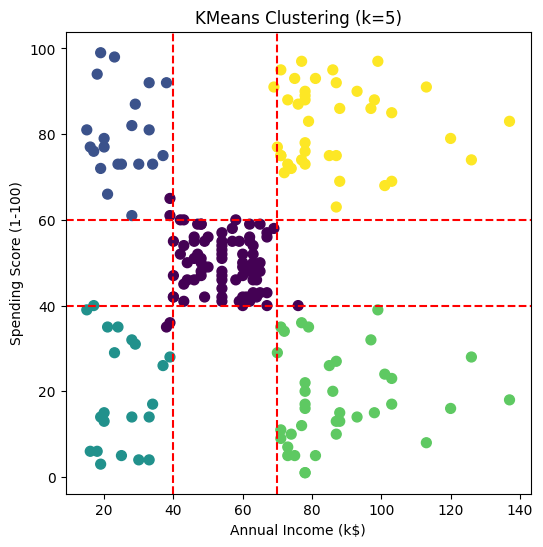

In [28]:
k_best = 5

kmeans = KMeans(n_clusters = k_best, n_init = 10, random_state = 42)
labels = kmeans.fit_predict(X_new)

inertia = kmeans.inertia_
silhouette_avg = silhouette_score(X_new, labels)

plt.figure(figsize=(6,6))
plt.scatter(X_final["Annual Income (k$)"], X_final["Spending Score (1-100)"], c=labels, cmap="viridis", s=50)

plt.axvline(x=40, color='red', linestyle='--', linewidth=1.5, label=f'Annual Income Mean')
plt.axvline(x=70, color='red', linestyle='--', linewidth=1.5, label=f'Annual Income Mean')
plt.axhline(y=60, color='red', linestyle='--', linewidth=1.5, label=f'Spending Score Mean')
plt.axhline(y=40, color='red', linestyle='--', linewidth=1.5, label=f'Spending Score Mean')

plt.title(f"KMeans Clustering (k={k_best})")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.show()

We can observe distinct regions corresponding to specific clusters, as well as areas with no customers. The following table provides valuable insights for the marketing team on how to target specific strategies and identifies the intervals of interest.

| Cluster   | Annual Income | Spending Score |
|-----------|---------------|----------------|
| Cluster 1 | ≤ 40          | ≤ 40           |
| Cluster 2 | ≤ 40          | ≥ 60           |
| Cluster 3 | ≥ 70          | ≤ 40           |
| Cluster 4 | ≥ 70          | ≥ 60           |
| Cluster 5 | [40, 70]      | [40, 60]       |


## Exporting Model

In [29]:
import joblib

joblib.dump(final_model, "customer_segmentation_model")

['customer_segmentation_model']